In [1]:
import pandas as pd
import time
import datetime
import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#upload data from csv 
Catskills = pd.read_csv("CatskillsDataset_csv.csv")


We've imported our packages and uploaded our dataset correctly. The data contains the location of each mountain as well as every time it was hiked. We need to convert this into a set of lists with the coordinates paired with the unix time 

In [2]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov','Dec']
mountain_coordinates = []
mountain_time = []

date_range = pd.date_range('2012-03-24', periods=2801, freq='D')
dates_in_grid = pd.DataFrame({ 'Date': date_range, 'Mileage' : 0}) 
dates_in_grid.set_index('Date')

for i in range(len(Catskills)):
    for month in months: 
        # Start by creating a list of coordinates
        lat = Catskills.loc[i, 'Latitude']
        long = Catskills.loc[i, 'Longitude']
        coordinates = [long, lat]
        mountain_coordinates.append(coordinates)
        
        #Next we'll make a list of times 
        date_string = Catskills.loc[i, month]
        unix_time_for_hike = time.mktime(datetime.datetime.strptime(date_string, "%m/%d/%Y").timetuple()) * 1000
        #hike_time = convertTuple(unix_time_for_hike)
        mountain_time.append(unix_time_for_hike)
        
        #also going to create our full time-series dataset of day and mileage
        date_formatted = datetime.datetime.strptime(date_string, "%m/%d/%Y").strftime('%Y-%m-%d')
        dates_in_grid.loc[dates_in_grid['Date'] == date_formatted, ['Mileage']] = dates_in_grid.loc[dates_in_grid['Date'] == date_formatted, ['Mileage']] + Catskills.loc[i, 'Mileage']

mountain_data = pd.DataFrame(
    {'coordinates': mountain_coordinates,
     'time': mountain_time       
    })

mountain_data.sort_values(by=['time'], inplace=True)


        Date  Mileage
0 2012-03-24        0
1 2012-03-25        0
2 2012-03-26        0
3 2012-03-27        0
4 2012-03-28        0


In [3]:
#Create base Catskills map
m = folium.Map(
    location=[42.106020, -74.307206],
    zoom_start = 10,
    tiles='Stamen Terrain'
)

In [4]:
coordinates = mountain_data['coordinates']
times = mountain_data['time'] 

hike_list = []

for i in range(len(times)):
    hike = {
            'type': 'Feature',
            'geometry': {
            'type': 'Point',
            'coordinates': coordinates[i]
        },
        'properties': {
            'time': times[i]
    }}
        
    hike_list.append(hike)
    

TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': hike_list},
    period='P6D',
    duration='P1M',
    auto_play=True,
    loop=False,
    loop_button=True,
    date_options='MM/DD/YYYY',
).add_to(m)

In [5]:
# we can save our map directly as an html file 
m.save("CatskillsMap.html")
# the 'm' command will display our map directly in the notebook
m

In [6]:
#Create cumulative mileage column in our grid_dates dataframe 
dates_in_grid['CumMileage'] = dates_in_grid['Mileage'].cumsum()
dates_in_grid['Days'] = range(1,2802)

           Date  Mileage  CumMileage  Days
2701 2019-08-16      0.0      2074.2  2702
2702 2019-08-17      0.0      2074.2  2703
2703 2019-08-18      0.0      2074.2  2704
2704 2019-08-19      0.0      2074.2  2705
2705 2019-08-20      0.0      2074.2  2706
...         ...      ...         ...   ...
2796 2019-11-19      0.0      2108.5  2797
2797 2019-11-20      0.0      2108.5  2798
2798 2019-11-21      0.0      2108.5  2799
2799 2019-11-22      0.0      2108.5  2800
2800 2019-11-23      6.5      2115.0  2801

[100 rows x 4 columns]


<IPython.core.display.Javascript object>


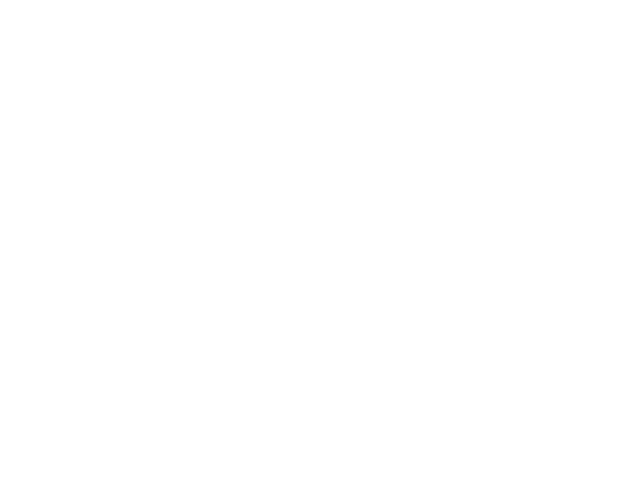

KeyboardInterrupt: 

In [7]:
# this next set of code creates our cumulative mileage figure
fig = plt.figure()
ax = plt.axes(xlim=(0, 2805), ylim=(0,2300))
line, = ax.plot([], [], lw=3)

# setting the axis tick labels over time consisted of creating a proportional number (out of 2801) for each 'year' label
# so it looked correct on the map 
ax.set_xticks([0,305,670,1035,1400,1765,2131,2497])
ax.set_xticklabels(['2012','2013','2014','2015','2016','2017','2018','2019'])
plt.title("Cumulative Mileage While Hiking the Grid")
plt.xlabel("Year")
plt.ylabel("Miles")

# these functions create our actual animation 
def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = dates_in_grid['Days'].iloc[:int(i+1)]
    y = dates_in_grid['CumMileage'].iloc[:int(i+1)]
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=2801, interval=10, blit=True, repeat=False)

# this section saves our animation as a video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

anim.save('mileage.mp4',writer=writer)

In [2]:
# this set of code creates our scatter plot of the grid filling in 

# remember, due to the difficulty of working with this data we created another csv in Excel
CatskillsScatter = pd.read_csv("CatskillsScatter.csv")

# setting up the coordinates list in a data frame (the -0.5 offsets the point to the correct place in the 'grid')
grids_list = []

for i in range(len(CatskillsScatter)):
    x = CatskillsScatter.iloc[i, 2] - 0.5
    y = CatskillsScatter.iloc[i, 3] - 0.5
    coordinate_list = [x,y]
    grids_list.append(coordinate_list)
    
# set up grid
a = range(0,13)
b = range(0,36)

# here we're creating a custom marker (rectangle)
v_val=1
h_val=3.2
verts = list(zip([-h_val,h_val,h_val,-h_val],[-v_val,-v_val,v_val,v_val]))


In [1]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(xlim=(0, 12), ylim=(0,35))
scat = ax.scatter([], [], s=2080, c='green', marker=verts)

# setting up the plot to be a 'grid'
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(["",'Jan    ','Feb    ','Mar    ','Apr    ','May    ','Jun    ','Jul    ','Aug    ','Sep    ','Oct    ','Nov    ','Dec    ', ""])
plt.xticks(ha='right')
ax.set_yticks(b)
plt.yticks(va='bottom')
ax.set_yticklabels(Catskills['Mountain'].iloc[::-1])
plt.title("Catskills 3500' Grid")
plt.xlabel("Month")
plt.grid(b=True, which='both')

# we require a tight layout due to the long mountain names 
plt.tight_layout()

# our function for the scatter 
def init():
    scat.set_offsets([])
    return scat,
def animate(i):
    data = grids_list[:i+1]
    scat.set_offsets(data)
    return scat,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=2805, interval=10, blit=True, repeat=False)

# again, saving the animation as a video file 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

anim.save('grid.mp4',writer=writer)

NameError: name 'plt' is not defined